# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import warnings

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
# sort dfdata based on longitude
dfdata = dfdata.sort_values("longitude")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
5962,-180,38,4,-5425.0,NaN,5.702333,NaN,427.678925,34.342628,NaN,15.691460
5757,-180,39,4,-5335.0,NaN,5.829761,NaN,497.673096,34.254448,NaN,14.695810
32077,-180,-55,4,-5287.0,NaN,6.456027,NaN,335.052032,34.125984,NaN,6.751073
5562,-180,40,4,-5241.0,NaN,5.968406,NaN,584.339844,34.158997,NaN,13.663589


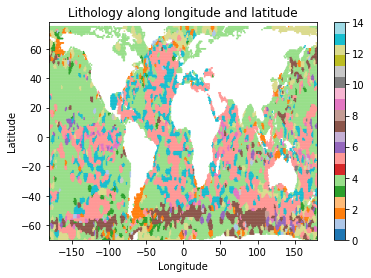

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = pl.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

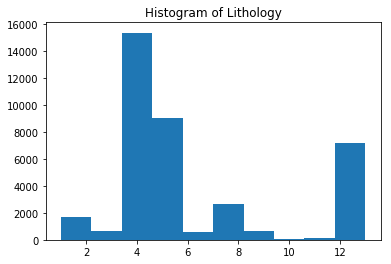

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    pl.hist(y)
    pl.title(title)
    pl.show()

draw_hist(y, "Histogram of Lithology")

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.

In [4]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
warnings.simplefilter("ignore")

Using Theano backend.


### Data preprocessing
* Normalize features X
* Onehot multiclass target Y

In [5]:
# obtain list of feature names
training_data = dfdata.copy()
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# extract X and Y
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

### Construct neural network
The neural network has the following structure:
- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Output layer

In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# parameters for hidden layers
activation = "relu"
dropout_ratio = 0.1
initializer = "random_uniform"
dropout_ratio = 0.2
numclass = dummy_Y.shape[1]
N, d = X.shape

# construct layers
inputs = Input(shape=(d,))
layer = Dense(64, activation=activation, kernel_initializer=initializer)(inputs)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(64, activation=activation, kernel_initializer=initializer)(layer)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(32, activation=activation, kernel_initializer=initializer)(layer)
prediction = Dense(numclass, activation="softmax")(layer)

# create model
model = Model(inputs=inputs, outputs=prediction)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                429       
Total para

Train on 24351 samples, validate on 6088 samples
Epoch 1/300
24351/24351 [==============================] - 2s 97us/step - loss: 1.4899 - acc: 0.4603 - val_loss: 1.6744 - val_acc: 0.4634
Epoch 2/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.3896 - acc: 0.5012 - val_loss: 1.6831 - val_acc: 0.4759
Epoch 3/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.3648 - acc: 0.5113 - val_loss: 1.6878 - val_acc: 0.4790
Epoch 4/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.3475 - acc: 0.5168 - val_loss: 1.6382 - val_acc: 0.4780
Epoch 5/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.3299 - acc: 0.5214 - val_loss: 1.5969 - val_acc: 0.4857
Epoch 6/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.3157 - acc: 0.5264 - val_loss: 1.6120 - val_acc: 0.4759
Epoch 7/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.3072 - acc: 0.5261 - val_loss: 1.6128 -

24351/24351 [==============================] - 2s 103us/step - loss: 1.1653 - acc: 0.5732 - val_loss: 1.7413 - val_acc: 0.4737
Epoch 60/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.1592 - acc: 0.5709 - val_loss: 1.7450 - val_acc: 0.4691
Epoch 61/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.1674 - acc: 0.5692 - val_loss: 1.8052 - val_acc: 0.4630
Epoch 62/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1608 - acc: 0.5683 - val_loss: 1.7628 - val_acc: 0.4683
Epoch 63/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1603 - acc: 0.5691 - val_loss: 1.7922 - val_acc: 0.4639
Epoch 64/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1605 - acc: 0.5712 - val_loss: 1.8090 - val_acc: 0.4639
Epoch 65/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.1601 - acc: 0.5697 - val_loss: 1.7514 - val_acc: 0.4647
Epoch 66/300
24351/24351 [=======

24351/24351 [==============================] - 2s 100us/step - loss: 1.1352 - acc: 0.5801 - val_loss: 1.7517 - val_acc: 0.4517
Epoch 118/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.1399 - acc: 0.5757 - val_loss: 1.7547 - val_acc: 0.4663
Epoch 119/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.1371 - acc: 0.5826 - val_loss: 1.8147 - val_acc: 0.4491
Epoch 120/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1368 - acc: 0.5808 - val_loss: 1.7692 - val_acc: 0.4606
Epoch 121/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.1404 - acc: 0.5781 - val_loss: 1.7631 - val_acc: 0.4625
Epoch 122/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1334 - acc: 0.5799 - val_loss: 1.8078 - val_acc: 0.4609
Epoch 123/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.1446 - acc: 0.5800 - val_loss: 1.8060 - val_acc: 0.4599
Epoch 124/300
24351/24351 [====

24351/24351 [==============================] - 2s 100us/step - loss: 1.1234 - acc: 0.5835 - val_loss: 1.8140 - val_acc: 0.4561
Epoch 176/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1291 - acc: 0.5844 - val_loss: 1.8538 - val_acc: 0.4637
Epoch 177/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.1269 - acc: 0.5799 - val_loss: 1.8554 - val_acc: 0.4514
Epoch 178/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1281 - acc: 0.5820 - val_loss: 1.8710 - val_acc: 0.4515
Epoch 179/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1224 - acc: 0.5819 - val_loss: 1.8530 - val_acc: 0.4570
Epoch 180/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.1241 - acc: 0.5845 - val_loss: 1.8459 - val_acc: 0.4419
Epoch 181/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1222 - acc: 0.5851 - val_loss: 1.9100 - val_acc: 0.4476
Epoch 182/300
24351/24351 [=

24351/24351 [==============================] - 2s 100us/step - loss: 1.1259 - acc: 0.5868 - val_loss: 1.7525 - val_acc: 0.4727
Epoch 234/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.1241 - acc: 0.5878 - val_loss: 1.7948 - val_acc: 0.4709
Epoch 235/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1161 - acc: 0.5874 - val_loss: 1.8735 - val_acc: 0.4504
Epoch 236/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.1242 - acc: 0.5849 - val_loss: 1.8561 - val_acc: 0.4364
Epoch 237/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.1203 - acc: 0.5849 - val_loss: 1.8461 - val_acc: 0.4422
Epoch 238/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1198 - acc: 0.5858 - val_loss: 1.8879 - val_acc: 0.4617
Epoch 239/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1168 - acc: 0.5856 - val_loss: 1.8345 - val_acc: 0.4639
Epoch 240/300
24351/24351 [

24351/24351 [==============================] - 2s 100us/step - loss: 1.1120 - acc: 0.5912 - val_loss: 1.8724 - val_acc: 0.4624
Epoch 292/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1167 - acc: 0.5881 - val_loss: 1.8234 - val_acc: 0.4667
Epoch 293/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1088 - acc: 0.5945 - val_loss: 1.8577 - val_acc: 0.4673
Epoch 294/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.1140 - acc: 0.5895 - val_loss: 1.8917 - val_acc: 0.4446
Epoch 295/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.1095 - acc: 0.5909 - val_loss: 1.9142 - val_acc: 0.4473
Epoch 296/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1231 - acc: 0.5845 - val_loss: 1.8706 - val_acc: 0.4601
Epoch 297/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1173 - acc: 0.5853 - val_loss: 1.8740 - val_acc: 0.4598
Epoch 298/300
24351/24351 [==

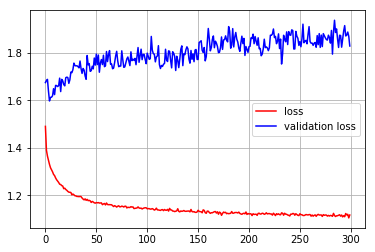

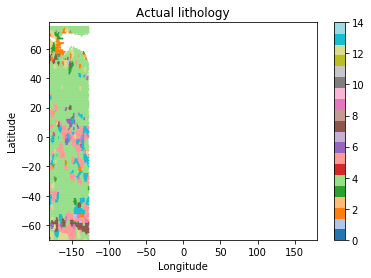

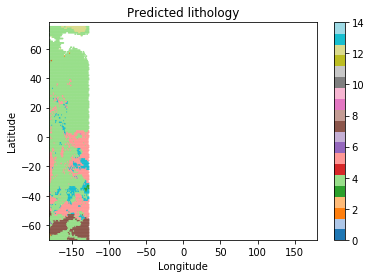

Train on 24351 samples, validate on 6088 samples
Epoch 1/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.1996 - acc: 0.5838 - val_loss: 1.7430 - val_acc: 0.4625
Epoch 2/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.1729 - acc: 0.5872 - val_loss: 1.7586 - val_acc: 0.4548
Epoch 3/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.1568 - acc: 0.5897 - val_loss: 1.7337 - val_acc: 0.4667
Epoch 4/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.1490 - acc: 0.5939 - val_loss: 1.7625 - val_acc: 0.4652
Epoch 5/300
24351/24351 [==============================] - 2s 103us/step - loss: 1.1431 - acc: 0.5978 - val_loss: 1.7695 - val_acc: 0.4616
Epoch 6/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.1428 - acc: 0.5980 - val_loss: 1.7392 - val_acc: 0.4543
Epoch 7/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.1363 - acc: 0.5978 - val_loss: 1.7

24351/24351 [==============================] - 2s 101us/step - loss: 1.0908 - acc: 0.6087 - val_loss: 1.7587 - val_acc: 0.4602
Epoch 60/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.0817 - acc: 0.6125 - val_loss: 1.7626 - val_acc: 0.4744
Epoch 61/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0869 - acc: 0.6119 - val_loss: 1.7920 - val_acc: 0.4599
Epoch 62/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.0810 - acc: 0.6102 - val_loss: 1.8158 - val_acc: 0.4596
Epoch 63/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0935 - acc: 0.6097 - val_loss: 1.7745 - val_acc: 0.4588
Epoch 64/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0848 - acc: 0.6106 - val_loss: 1.7272 - val_acc: 0.4765
Epoch 65/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.0800 - acc: 0.6123 - val_loss: 1.7377 - val_acc: 0.4809
Epoch 66/300
24351/24351 [=======

Epoch 118/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0754 - acc: 0.6142 - val_loss: 1.8822 - val_acc: 0.4364
Epoch 119/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0770 - acc: 0.6153 - val_loss: 1.8008 - val_acc: 0.4524
Epoch 120/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0754 - acc: 0.6137 - val_loss: 1.8290 - val_acc: 0.4506
Epoch 121/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0663 - acc: 0.6156 - val_loss: 1.8161 - val_acc: 0.4542
Epoch 122/300
24351/24351 [==============================] - 2s 98us/step - loss: 1.0673 - acc: 0.6178 - val_loss: 1.7832 - val_acc: 0.4547
Epoch 123/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0723 - acc: 0.6152 - val_loss: 1.8158 - val_acc: 0.4471
Epoch 124/300
24351/24351 [==============================] - 2s 98us/step - loss: 1.0774 - acc: 0.6141 - val_loss: 1.8588 - val_acc: 0.4560
Epoch 125/300
2435

24351/24351 [==============================] - 2s 99us/step - loss: 1.0677 - acc: 0.6174 - val_loss: 1.8762 - val_acc: 0.4512
Epoch 177/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0630 - acc: 0.6186 - val_loss: 1.8153 - val_acc: 0.4675
Epoch 178/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0623 - acc: 0.6180 - val_loss: 1.8468 - val_acc: 0.4565
Epoch 179/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0718 - acc: 0.6174 - val_loss: 1.8414 - val_acc: 0.4602
Epoch 180/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0624 - acc: 0.6176 - val_loss: 1.8092 - val_acc: 0.4473
Epoch 181/300
24351/24351 [==============================] - 2s 98us/step - loss: 1.0714 - acc: 0.6146 - val_loss: 1.8140 - val_acc: 0.4599
Epoch 182/300
24351/24351 [==============================] - 2s 98us/step - loss: 1.0632 - acc: 0.6178 - val_loss: 1.8532 - val_acc: 0.4515
Epoch 183/300
24351/24351 [=======

24351/24351 [==============================] - 2s 99us/step - loss: 1.0655 - acc: 0.6201 - val_loss: 1.8580 - val_acc: 0.4512
Epoch 235/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0597 - acc: 0.6203 - val_loss: 1.8685 - val_acc: 0.4560
Epoch 236/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0609 - acc: 0.6139 - val_loss: 1.8465 - val_acc: 0.4782
Epoch 237/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0640 - acc: 0.6221 - val_loss: 1.8606 - val_acc: 0.4617
Epoch 238/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0588 - acc: 0.6191 - val_loss: 1.8423 - val_acc: 0.4625
Epoch 239/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0642 - acc: 0.6205 - val_loss: 1.8665 - val_acc: 0.4625
Epoch 240/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0661 - acc: 0.6150 - val_loss: 1.8479 - val_acc: 0.4547
Epoch 241/300
24351/24351 [=======

24351/24351 [==============================] - 2s 99us/step - loss: 1.0599 - acc: 0.6189 - val_loss: 1.8529 - val_acc: 0.4442
Epoch 293/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0612 - acc: 0.6197 - val_loss: 1.8898 - val_acc: 0.4399
Epoch 294/300
24351/24351 [==============================] - 2s 98us/step - loss: 1.0636 - acc: 0.6171 - val_loss: 1.8794 - val_acc: 0.4368
Epoch 295/300
24351/24351 [==============================] - 2s 98us/step - loss: 1.0624 - acc: 0.6195 - val_loss: 1.8640 - val_acc: 0.4550
Epoch 296/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0611 - acc: 0.6191 - val_loss: 1.8477 - val_acc: 0.4463
Epoch 297/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0573 - acc: 0.6187 - val_loss: 1.9002 - val_acc: 0.4414
Epoch 298/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0617 - acc: 0.6155 - val_loss: 1.9323 - val_acc: 0.4382
Epoch 299/300
24351/24351 [=======

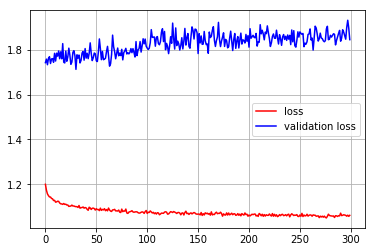

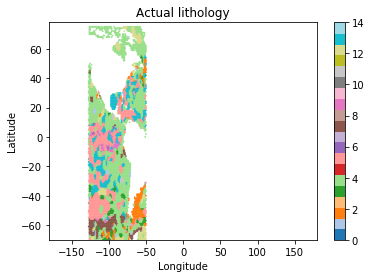

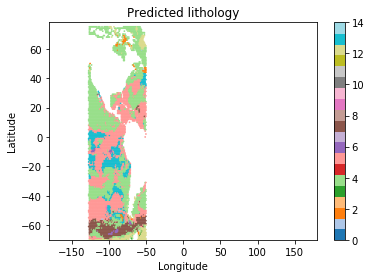

Train on 24351 samples, validate on 6088 samples
Epoch 1/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.2183 - acc: 0.5849 - val_loss: 1.7716 - val_acc: 0.4593
Epoch 2/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.1777 - acc: 0.5918 - val_loss: 1.7695 - val_acc: 0.4722
Epoch 3/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.1606 - acc: 0.5960 - val_loss: 1.8036 - val_acc: 0.4570
Epoch 4/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.1585 - acc: 0.5972 - val_loss: 1.8097 - val_acc: 0.4552
Epoch 5/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1501 - acc: 0.5997 - val_loss: 1.8194 - val_acc: 0.4484
Epoch 6/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.1444 - acc: 0.5989 - val_loss: 1.8026 - val_acc: 0.4563
Epoch 7/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.1440 - acc: 0.5963 - val_loss: 1.8022 -

24351/24351 [==============================] - 2s 101us/step - loss: 1.0906 - acc: 0.6168 - val_loss: 1.8584 - val_acc: 0.4496
Epoch 60/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0916 - acc: 0.6134 - val_loss: 1.8229 - val_acc: 0.4547
Epoch 61/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0937 - acc: 0.6122 - val_loss: 1.8699 - val_acc: 0.4471
Epoch 62/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0924 - acc: 0.6135 - val_loss: 1.8590 - val_acc: 0.4442
Epoch 63/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0887 - acc: 0.6152 - val_loss: 1.8431 - val_acc: 0.4465
Epoch 64/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0855 - acc: 0.6154 - val_loss: 1.8250 - val_acc: 0.4534
Epoch 65/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.1032 - acc: 0.6088 - val_loss: 1.8549 - val_acc: 0.4235
Epoch 66/300
24351/24351 [==========

24351/24351 [==============================] - 2s 99us/step - loss: 1.0882 - acc: 0.6151 - val_loss: 1.8847 - val_acc: 0.4612
Epoch 118/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0912 - acc: 0.6110 - val_loss: 1.8813 - val_acc: 0.4524
Epoch 119/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0854 - acc: 0.6183 - val_loss: 1.8625 - val_acc: 0.4634
Epoch 120/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0876 - acc: 0.6139 - val_loss: 1.8023 - val_acc: 0.4655
Epoch 121/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0813 - acc: 0.6160 - val_loss: 1.8775 - val_acc: 0.4655
Epoch 122/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0870 - acc: 0.6163 - val_loss: 1.8461 - val_acc: 0.4479
Epoch 123/300
24351/24351 [==============================] - 2s 99us/step - loss: 1.0865 - acc: 0.6174 - val_loss: 1.9087 - val_acc: 0.4450
Epoch 124/300
24351/24351 [==

24351/24351 [==============================] - 2s 100us/step - loss: 1.0857 - acc: 0.6146 - val_loss: 1.9497 - val_acc: 0.4532
Epoch 176/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0747 - acc: 0.6194 - val_loss: 1.9613 - val_acc: 0.4501
Epoch 177/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0812 - acc: 0.6155 - val_loss: 1.9498 - val_acc: 0.4565
Epoch 178/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0830 - acc: 0.6182 - val_loss: 1.9301 - val_acc: 0.4563
Epoch 179/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0797 - acc: 0.6164 - val_loss: 1.9115 - val_acc: 0.4690
Epoch 180/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0851 - acc: 0.6148 - val_loss: 1.9531 - val_acc: 0.4555
Epoch 181/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0787 - acc: 0.6206 - val_loss: 1.9685 - val_acc: 0.4468
Epoch 182/300
24351/24351 [

24351/24351 [==============================] - 2s 100us/step - loss: 1.0802 - acc: 0.6189 - val_loss: 1.9468 - val_acc: 0.4573
Epoch 234/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0790 - acc: 0.6208 - val_loss: 1.9482 - val_acc: 0.4466
Epoch 235/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.0833 - acc: 0.6202 - val_loss: 2.0208 - val_acc: 0.4407
Epoch 236/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0805 - acc: 0.6180 - val_loss: 1.9751 - val_acc: 0.4658
Epoch 237/300
24351/24351 [==============================] - 2s 100us/step - loss: 1.0951 - acc: 0.6202 - val_loss: 1.9464 - val_acc: 0.4507
Epoch 238/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.0842 - acc: 0.6178 - val_loss: 1.9556 - val_acc: 0.4681
Epoch 239/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.0877 - acc: 0.6174 - val_loss: 1.9567 - val_acc: 0.4502
Epoch 240/300
24351/24351 [

Epoch 291/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.0812 - acc: 0.6149 - val_loss: 1.9864 - val_acc: 0.4711
Epoch 292/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.0725 - acc: 0.6197 - val_loss: 2.0156 - val_acc: 0.4630
Epoch 293/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0760 - acc: 0.6190 - val_loss: 1.9853 - val_acc: 0.4676
Epoch 294/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0703 - acc: 0.6227 - val_loss: 1.9534 - val_acc: 0.4709
Epoch 295/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.0825 - acc: 0.6208 - val_loss: 1.9977 - val_acc: 0.4450
Epoch 296/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.0737 - acc: 0.6231 - val_loss: 2.0020 - val_acc: 0.4688
Epoch 297/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0783 - acc: 0.6185 - val_loss: 1.9579 - val_acc: 0.4584
Epoch 298/300

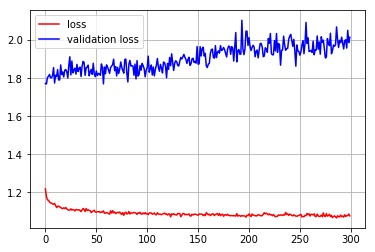

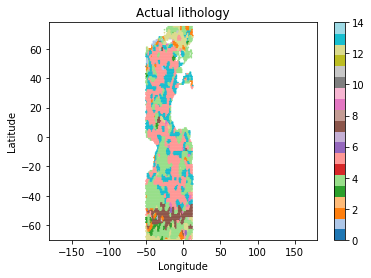

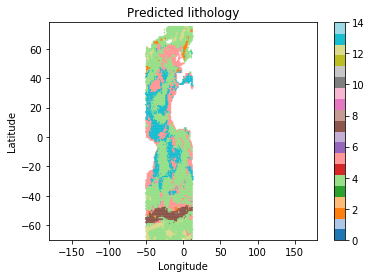

Train on 24351 samples, validate on 6088 samples
Epoch 1/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.1826 - acc: 0.5777 - val_loss: 1.9263 - val_acc: 0.4760
Epoch 2/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.1562 - acc: 0.5834 - val_loss: 1.8997 - val_acc: 0.4757
Epoch 3/300
24351/24351 [==============================] - 3s 104us/step - loss: 1.1466 - acc: 0.5901 - val_loss: 1.8690 - val_acc: 0.4828
Epoch 4/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.1428 - acc: 0.5914 - val_loss: 1.8824 - val_acc: 0.4647
Epoch 5/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.1328 - acc: 0.5904 - val_loss: 1.9489 - val_acc: 0.4675
Epoch 6/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.1320 - acc: 0.5946 - val_loss: 1.9245 - val_acc: 0.4655
Epoch 7/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.1339 - acc: 0.5915 - val_loss: 1.8

24351/24351 [==============================] - 2s 102us/step - loss: 1.0847 - acc: 0.6132 - val_loss: 1.9491 - val_acc: 0.4663
Epoch 60/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0855 - acc: 0.6110 - val_loss: 1.9011 - val_acc: 0.4780
Epoch 61/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0901 - acc: 0.6106 - val_loss: 1.9204 - val_acc: 0.4708
Epoch 62/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0836 - acc: 0.6117 - val_loss: 1.9171 - val_acc: 0.4798
Epoch 63/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0837 - acc: 0.6110 - val_loss: 1.8413 - val_acc: 0.4662
Epoch 64/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0814 - acc: 0.6102 - val_loss: 1.8869 - val_acc: 0.4547
Epoch 65/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0787 - acc: 0.6112 - val_loss: 1.9037 - val_acc: 0.4668
Epoch 66/300
24351/24351 [=======

24351/24351 [==============================] - 2s 102us/step - loss: 1.0670 - acc: 0.6161 - val_loss: 1.9474 - val_acc: 0.4665
Epoch 118/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.0738 - acc: 0.6167 - val_loss: 2.0125 - val_acc: 0.4453
Epoch 119/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0766 - acc: 0.6104 - val_loss: 2.0034 - val_acc: 0.4358
Epoch 120/300
24351/24351 [==============================] - 2s 101us/step - loss: 1.0731 - acc: 0.6123 - val_loss: 2.0209 - val_acc: 0.4483
Epoch 121/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0748 - acc: 0.6161 - val_loss: 2.0404 - val_acc: 0.4578
Epoch 122/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0750 - acc: 0.6151 - val_loss: 1.8902 - val_acc: 0.4545
Epoch 123/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0699 - acc: 0.6164 - val_loss: 1.9843 - val_acc: 0.4565
Epoch 124/300
24351/24351 [

24351/24351 [==============================] - 3s 103us/step - loss: 1.0735 - acc: 0.6149 - val_loss: 2.0998 - val_acc: 0.4543
Epoch 176/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0660 - acc: 0.6195 - val_loss: 2.0030 - val_acc: 0.4532
Epoch 177/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0665 - acc: 0.6171 - val_loss: 1.9844 - val_acc: 0.4625
Epoch 178/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0729 - acc: 0.6164 - val_loss: 1.9581 - val_acc: 0.4501
Epoch 179/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0738 - acc: 0.6162 - val_loss: 1.9913 - val_acc: 0.4699
Epoch 180/300
24351/24351 [==============================] - 2s 102us/step - loss: 1.0699 - acc: 0.6166 - val_loss: 2.0188 - val_acc: 0.4570
Epoch 181/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.0801 - acc: 0.6161 - val_loss: 2.0466 - val_acc: 0.4484
Epoch 182/300
24351/24351 [

24351/24351 [==============================] - 3s 103us/step - loss: 1.0665 - acc: 0.6203 - val_loss: 2.0014 - val_acc: 0.4591
Epoch 234/300
24351/24351 [==============================] - 3s 104us/step - loss: 1.0773 - acc: 0.6166 - val_loss: 1.9826 - val_acc: 0.4445
Epoch 235/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.0712 - acc: 0.6197 - val_loss: 2.0181 - val_acc: 0.4739
Epoch 236/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.0598 - acc: 0.6231 - val_loss: 2.0510 - val_acc: 0.4506
Epoch 237/300
24351/24351 [==============================] - 3s 104us/step - loss: 1.0638 - acc: 0.6189 - val_loss: 2.0170 - val_acc: 0.4499
Epoch 238/300
24351/24351 [==============================] - 3s 104us/step - loss: 1.0686 - acc: 0.6208 - val_loss: 2.0237 - val_acc: 0.4499
Epoch 239/300
24351/24351 [==============================] - 3s 107us/step - loss: 1.0705 - acc: 0.6199 - val_loss: 2.0574 - val_acc: 0.4392
Epoch 240/300
24351/24351 [

24351/24351 [==============================] - 3s 103us/step - loss: 1.0702 - acc: 0.6155 - val_loss: 2.2363 - val_acc: 0.4317
Epoch 292/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.0636 - acc: 0.6183 - val_loss: 2.1090 - val_acc: 0.4340
Epoch 293/300
24351/24351 [==============================] - 3s 104us/step - loss: 1.0603 - acc: 0.6201 - val_loss: 2.0742 - val_acc: 0.4491
Epoch 294/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.0546 - acc: 0.6199 - val_loss: 2.1225 - val_acc: 0.4440
Epoch 295/300
24351/24351 [==============================] - 3s 104us/step - loss: 1.0587 - acc: 0.6222 - val_loss: 2.0207 - val_acc: 0.4488
Epoch 296/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.0719 - acc: 0.6185 - val_loss: 2.1654 - val_acc: 0.4391
Epoch 297/300
24351/24351 [==============================] - 3s 103us/step - loss: 1.0717 - acc: 0.6169 - val_loss: 2.0995 - val_acc: 0.4450
Epoch 298/300
24351/24351 [

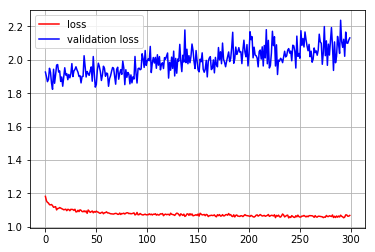

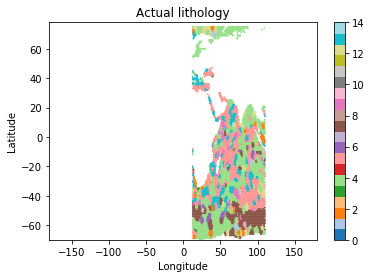

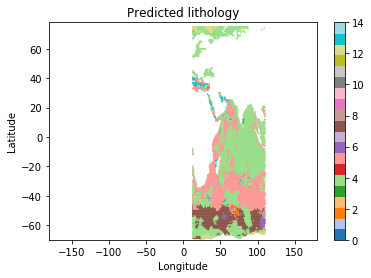

Train on 24352 samples, validate on 6088 samples
Epoch 1/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0909 - acc: 0.6175 - val_loss: 1.5832 - val_acc: 0.4639
Epoch 2/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0845 - acc: 0.6105 - val_loss: 1.5934 - val_acc: 0.4612
Epoch 3/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0767 - acc: 0.6153 - val_loss: 1.5671 - val_acc: 0.4676
Epoch 4/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0723 - acc: 0.6149 - val_loss: 1.5647 - val_acc: 0.4647
Epoch 5/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0688 - acc: 0.6134 - val_loss: 1.5424 - val_acc: 0.4724
Epoch 6/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0713 - acc: 0.6163 - val_loss: 1.5521 - val_acc: 0.4520
Epoch 7/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0657 - acc: 0.6162 - val_loss: 1.5

24352/24352 [==============================] - 3s 104us/step - loss: 1.0569 - acc: 0.6199 - val_loss: 1.6444 - val_acc: 0.4446
Epoch 60/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0538 - acc: 0.6215 - val_loss: 1.6417 - val_acc: 0.4373
Epoch 61/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0563 - acc: 0.6218 - val_loss: 1.5898 - val_acc: 0.4453
Epoch 62/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0646 - acc: 0.6187 - val_loss: 1.6635 - val_acc: 0.4391
Epoch 63/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0550 - acc: 0.6205 - val_loss: 1.6641 - val_acc: 0.4420
Epoch 64/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0533 - acc: 0.6223 - val_loss: 1.6574 - val_acc: 0.4415
Epoch 65/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0578 - acc: 0.6222 - val_loss: 1.6662 - val_acc: 0.4302
Epoch 66/300
24352/24352 [=======

24352/24352 [==============================] - 3s 103us/step - loss: 1.0459 - acc: 0.6248 - val_loss: 1.6448 - val_acc: 0.4304
Epoch 118/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0514 - acc: 0.6233 - val_loss: 1.7018 - val_acc: 0.4583
Epoch 119/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0501 - acc: 0.6210 - val_loss: 1.6655 - val_acc: 0.4479
Epoch 120/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0511 - acc: 0.6196 - val_loss: 1.6848 - val_acc: 0.4478
Epoch 121/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0547 - acc: 0.6246 - val_loss: 1.6938 - val_acc: 0.4368
Epoch 122/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0459 - acc: 0.6240 - val_loss: 1.6595 - val_acc: 0.4529
Epoch 123/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0531 - acc: 0.6222 - val_loss: 1.6620 - val_acc: 0.4341
Epoch 124/300
24352/24352 [

24352/24352 [==============================] - 3s 103us/step - loss: 1.0480 - acc: 0.6251 - val_loss: 1.7019 - val_acc: 0.4450
Epoch 176/300
24352/24352 [==============================] - 2s 103us/step - loss: 1.0471 - acc: 0.6255 - val_loss: 1.6683 - val_acc: 0.4308
Epoch 177/300
24352/24352 [==============================] - 2s 103us/step - loss: 1.0402 - acc: 0.6256 - val_loss: 1.7413 - val_acc: 0.4371
Epoch 178/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0402 - acc: 0.6242 - val_loss: 1.6943 - val_acc: 0.4351
Epoch 179/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0453 - acc: 0.6222 - val_loss: 1.6746 - val_acc: 0.4350
Epoch 180/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0394 - acc: 0.6268 - val_loss: 1.7328 - val_acc: 0.4446
Epoch 181/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0544 - acc: 0.6230 - val_loss: 1.6902 - val_acc: 0.4443
Epoch 182/300
24352/24352 [

24352/24352 [==============================] - 3s 104us/step - loss: 1.0382 - acc: 0.6258 - val_loss: 1.7445 - val_acc: 0.4287
Epoch 234/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0435 - acc: 0.6271 - val_loss: 1.7159 - val_acc: 0.4506
Epoch 235/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0454 - acc: 0.6265 - val_loss: 1.7785 - val_acc: 0.4450
Epoch 236/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0401 - acc: 0.6260 - val_loss: 1.8093 - val_acc: 0.4120
Epoch 237/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0416 - acc: 0.6271 - val_loss: 1.7679 - val_acc: 0.4284
Epoch 238/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0302 - acc: 0.6274 - val_loss: 1.8276 - val_acc: 0.4233
Epoch 239/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0401 - acc: 0.6261 - val_loss: 1.7679 - val_acc: 0.4433
Epoch 240/300
24352/24352 [

24352/24352 [==============================] - 3s 104us/step - loss: 1.0424 - acc: 0.6225 - val_loss: 1.7100 - val_acc: 0.4520
Epoch 292/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0527 - acc: 0.6249 - val_loss: 1.7612 - val_acc: 0.4461
Epoch 293/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0503 - acc: 0.6282 - val_loss: 1.7410 - val_acc: 0.4277
Epoch 294/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0461 - acc: 0.6240 - val_loss: 1.7500 - val_acc: 0.4506
Epoch 295/300
24352/24352 [==============================] - 3s 103us/step - loss: 1.0391 - acc: 0.6287 - val_loss: 1.7488 - val_acc: 0.4351
Epoch 296/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0523 - acc: 0.6273 - val_loss: 1.7359 - val_acc: 0.4529
Epoch 297/300
24352/24352 [==============================] - 3s 104us/step - loss: 1.0427 - acc: 0.6275 - val_loss: 1.7100 - val_acc: 0.4396
Epoch 298/300
24352/24352 [

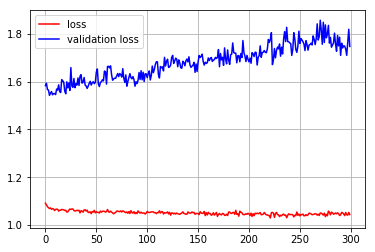

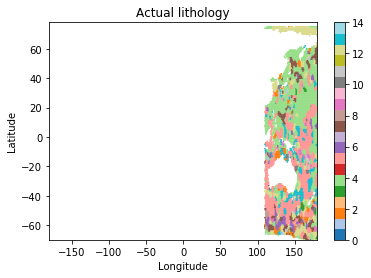

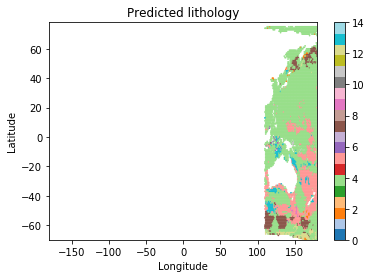

In [7]:
# parameters for training
epochs = 300
batch_size = 5
verbose = True

# use 5 fold cross validation without shuffle
kfold = KFold(n_splits=5, random_state=seed)
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values

# training
prediction = np.zeros((N, numclass))
for train_ind, test_ind in kfold.split(X):
    train_X, train_Y = X[train_ind], dummy_Y[train_ind]
    # record loss in training and validation
    history = History()
    model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=weight,
              validation_split=0.2, shuffle=True, callbacks=[history])
    # plot loss versus epochs
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    pl.plot(history.epoch, loss, "r-", label="loss")
    pl.plot(history.epoch, val_loss, "b-", label="validation loss")
    pl.grid()
    pl.legend()
    pl.show()
    # predict and draw scatterplot for prediction set
    mu = model.predict(X[test_ind])
    prediction[test_ind, :] = mu
    mean = np.argmax(mu, axis=1)
    draw_global(lon[test_ind], lat[test_ind], Y[test_ind] + 1, "Actual lithology")
    draw_global(lon[test_ind], lat[test_ind], mean + 1, "Predicted lithology")

### Validate

Accuracy = 0.4499724040053615


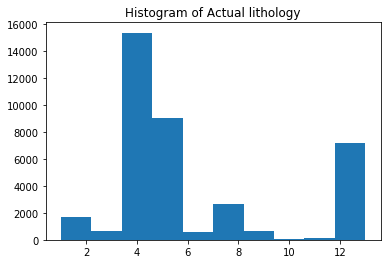

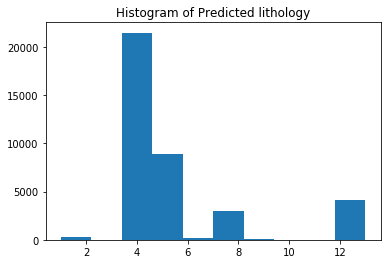

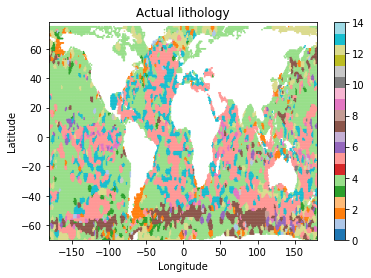

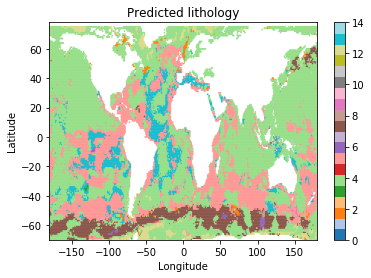

In [8]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values

mean = np.argmax(prediction, axis=1)
print("Accuracy = {}".format(accuracy_score(Y, mean)))
draw_hist(Y + 1, "Histogram of Actual lithology")
draw_hist(mean + 1, "Histogram of Predicted lithology")
draw_global(lon, lat, Y + 1, "Actual lithology")
draw_global(lon, lat, mean + 1, "Predicted lithology")

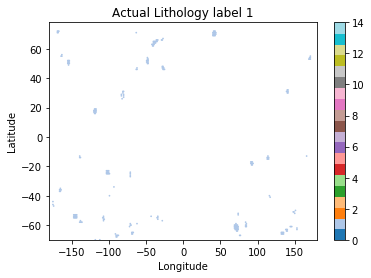

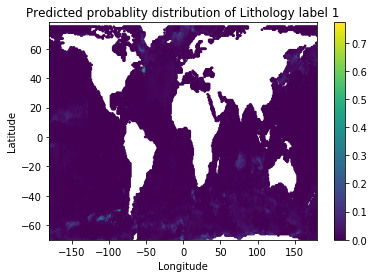

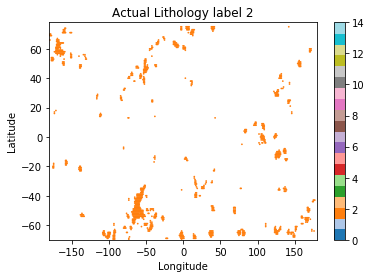

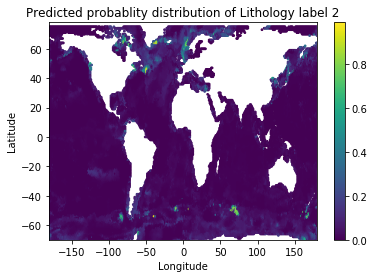

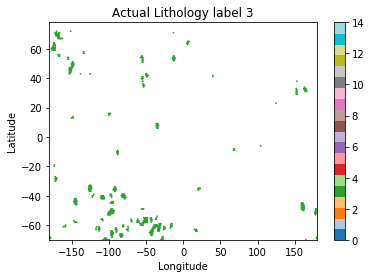

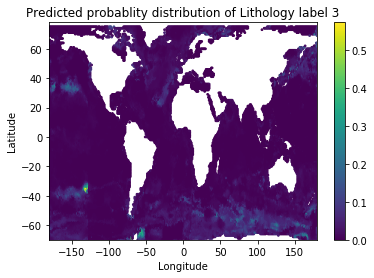

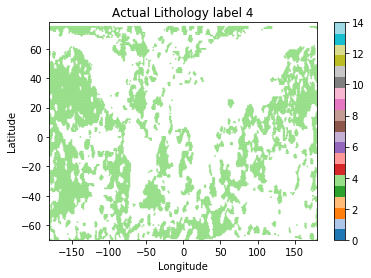

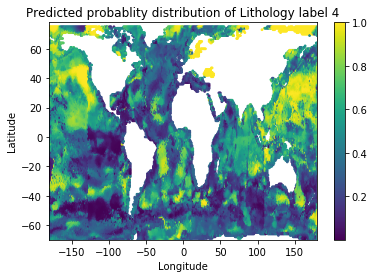

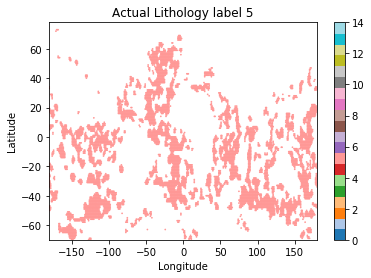

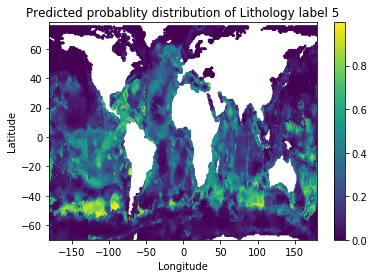

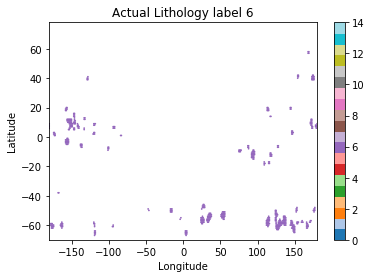

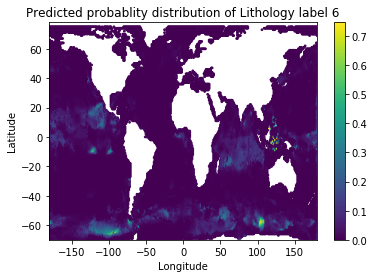

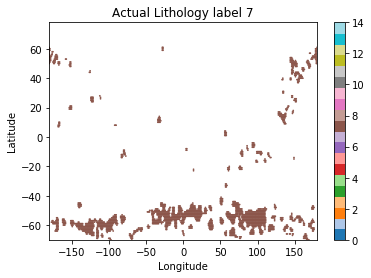

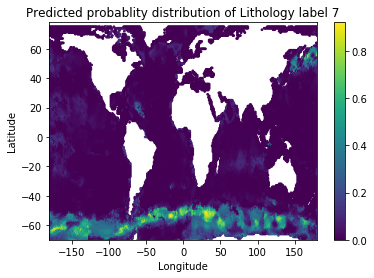

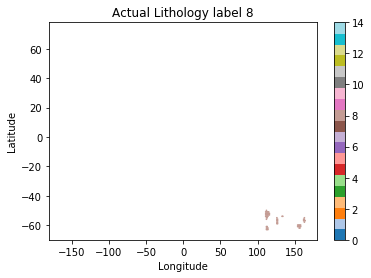

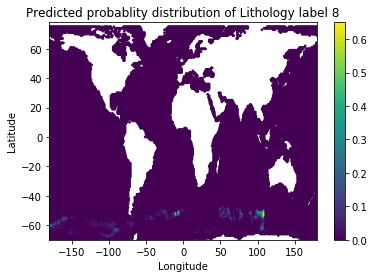

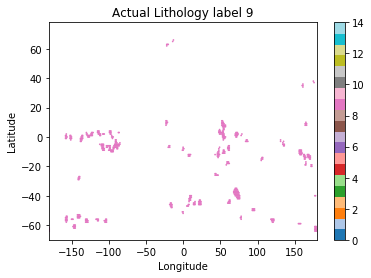

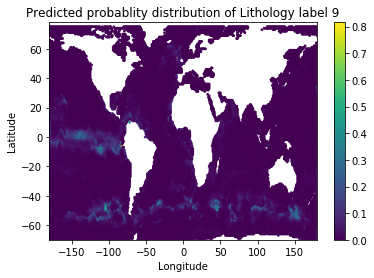

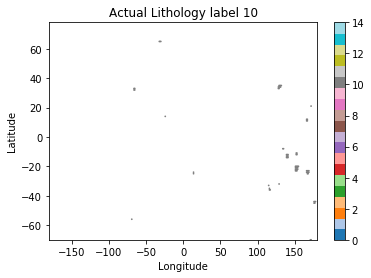

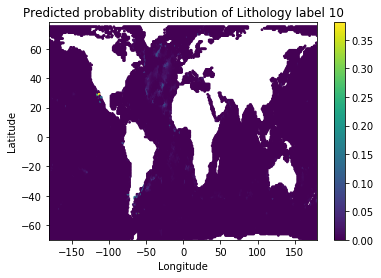

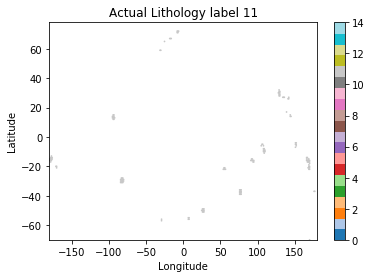

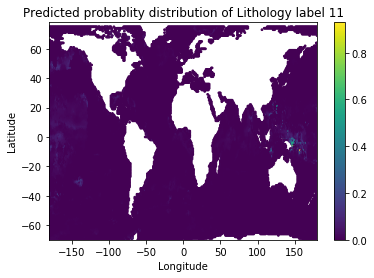

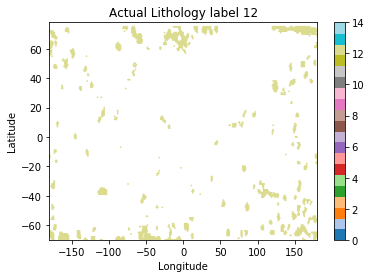

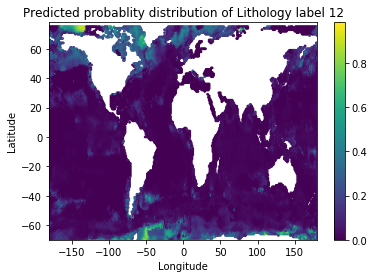

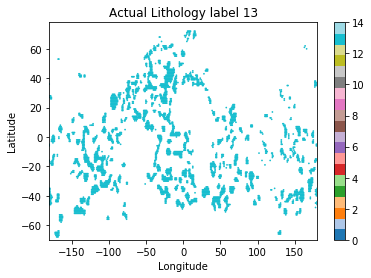

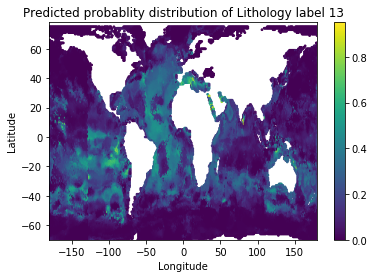

In [9]:
def draw_prob(lon, lat, p, title, size=3):
    sc = pl.scatter(lon, lat, s=size, c=p)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
    pl.close()
    
for i in range(13):
    common_part = "Lithology label {}".format(i + 1)
    title_p = "Predicted probablity distribution of {}".format(common_part)
    title_y = "Actual {}".format(common_part)
    # find Y_ts whose label is i + 1 and plot
    index = Y == i
    thisY = Y[Y == i] + 1
    draw_global(lon[index], lat[index], y=thisY, title=title_y)
    # plot prob distribution
    draw_prob(lon, lat, p = prediction[:,i], title=title_p)